In [50]:
import pandas as pd

In [51]:
df = pd.read_csv('ktm_clean.csv')

In [52]:
df.head()

,Date,aqi_value,aqi_category
0,2024-01-01,138.0,Unhealthy for Sensitive Groups
1,2024-01-02,116.0,Unhealthy for Sensitive Groups
2,2024-01-03,131.0,Unhealthy for Sensitive Groups
3,2024-01-04,140.0,Unhealthy for Sensitive Groups
4,2024-01-05,140.0,Unhealthy for Sensitive Groups


In [65]:
df.shape

(570, 2)

In [53]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [54]:
print(df.isnull().sum() / len(df) * 100)


aqi_value       0.526316
aqi_category    0.000000
dtype: float64


In [55]:
df[df['aqi_value'].isnull()]

,aqi_value,aqi_category
Date,,
2025-04-19,NaN,Unknown
2025-04-20,NaN,Unknown
2025-04-22,NaN,Unknown


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570 entries, 2024-01-01 to 2025-07-23
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   aqi_value     567 non-null    float64
 1   aqi_category  570 non-null    object 
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


In [58]:
df.index.min(), df.index.max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-07-23 00:00:00'))

In [41]:
# Sort the dataframe by date
df.sort_index(inplace=True)

In [42]:
# Drop the aqi_category column as it's not needed for the time series model
df.drop('aqi_category', axis=1, inplace=True)

In [43]:
# Display the first few rows to verify the changes
display(df.head())

,aqi_value
Date,
2024-01-01,138.0
2024-01-02,116.0
2024-01-03,131.0
2024-01-04,140.0
2024-01-05,140.0


In [66]:
# Use linear interpolation to fill small gaps in 'aqi_value'
df['aqi_value'] = df['aqi_value'].interpolate(method='linear')

# Verify that there are no more missing values
print(df.isnull().sum())

aqi_value       0
aqi_category    0
dtype: int64


In [67]:
# Count duplicate aqi_value entries for each day
duplicate_aqi_counts = df.groupby(df.index)['aqi_value'].value_counts()

# Filter to show only combinations that appear more than once
duplicate_aqi_counts = duplicate_aqi_counts[duplicate_aqi_counts > 1]

print("Frequency of duplicate aqi_value entries for each day:")
print(duplicate_aqi_counts)

Frequency of duplicate aqi_value entries for each day:
Series([], Name: count, dtype: int64)


In [68]:
# Aggregate duplicate aqi_value entries for each day using the mean
df_daily_mean = df.groupby(df.index)['aqi_value'].mean()

# Display the first few rows of the new dataframe
display(df_daily_mean.head())

# Update the original dataframe with the daily mean values
df = df_daily_mean.to_frame()

,aqi_value
Date,
2024-01-01,138.0
2024-01-02,116.0
2024-01-03,131.0
2024-01-04,140.0
2024-01-05,140.0


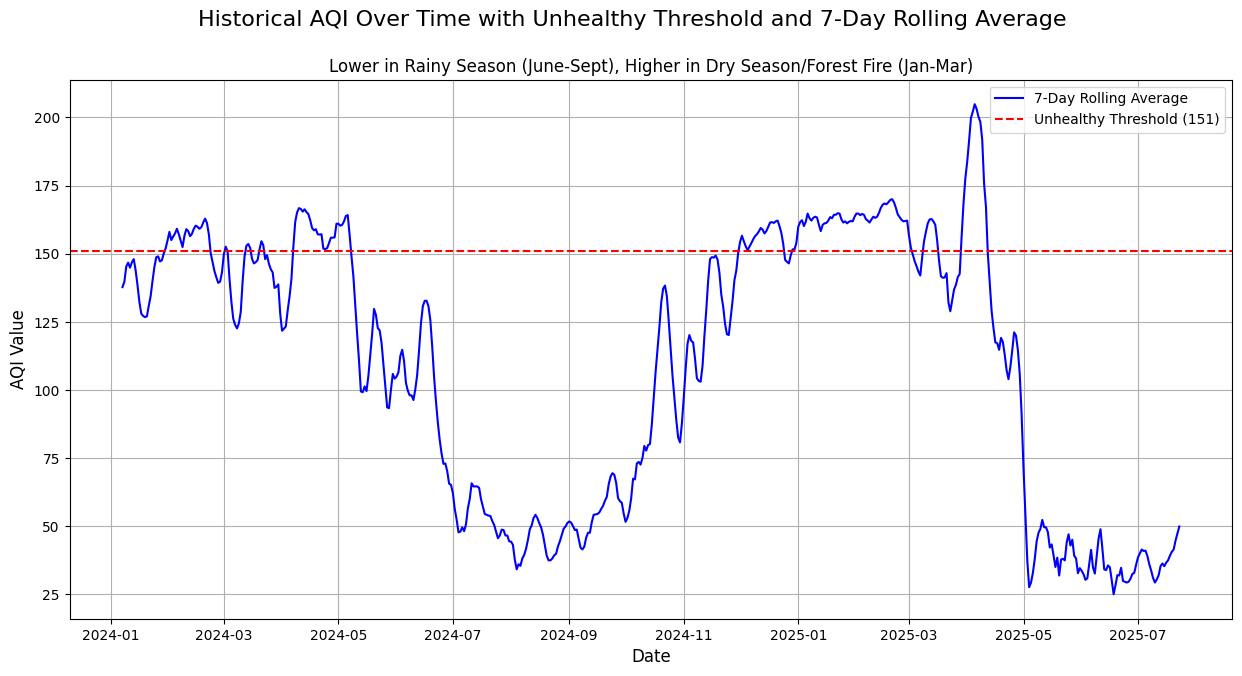

In [132]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the 7-day rolling average
df['aqi_value_rolling_avg_7'] = df['aqi_value'].rolling(window=7).mean()


# Plot AQI time series with 7-day rolling average
plt.figure(figsize=(15, 7))
# plt.plot(df.index, df['aqi_value'], color='blue', linestyle='-', label='Historical AQI')
plt.plot(df.index, df['aqi_value_rolling_avg_7'], color='blue', linestyle='-', label='7-Day Rolling Average')


# Add a horizontal line at the 'Unhealthy' threshold (AQI = 151)
plt.axhline(y=151, color='red', linestyle='--', label='Unhealthy Threshold (151)')

plt.suptitle('Historical AQI Over Time with Unhealthy Threshold and 7-Day Rolling Average', fontsize=16)
plt.title('Lower in Rainy Season (June-Sept), Higher in Dry Season/Forest Fire (Jan-Mar)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

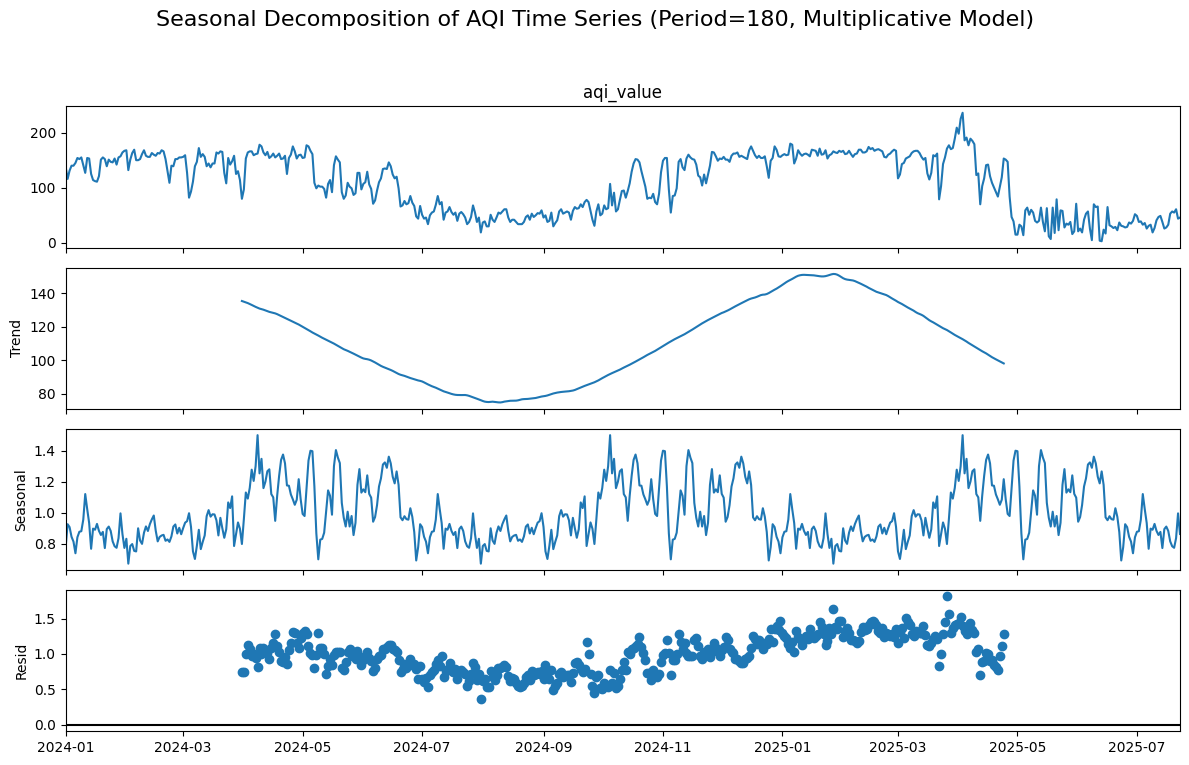

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose time series (using multiplicative model with period=180)
decomposition = seasonal_decompose(df['aqi_value'], model='multiplicative', period=180)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Seasonal Decomposition of AQI Time Series (Period=180, Multiplicative Model)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [82]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['aqi_value'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] > 0.05:
    print('The time series is likely non-stationary.')
else:
    print('The time series is likely stationary.')

ADF Statistic: -1.779350
p-value: 0.390761
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570
The time series is likely non-stationary.


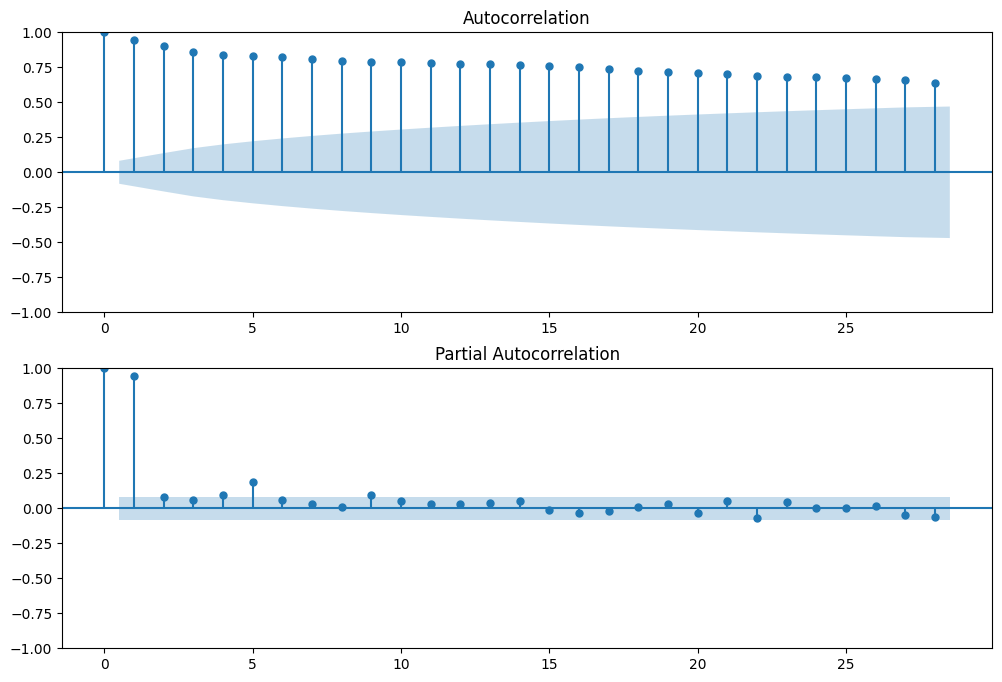

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['aqi_value'], ax=axes[0])
plot_pacf(df['aqi_value'], ax=axes[1])
plt.show()

In [84]:
# Apply first-order differencing
df['aqi_value_diff'] = df['aqi_value'].diff()

# Drop the first row with NaN
df_diff = df['aqi_value_diff'].dropna()

# Display the first few rows of the differenced series
display(df_diff.head())

,aqi_value_diff
Date,
2024-01-02,-22.0
2024-01-03,15.0
2024-01-04,9.0
2024-01-05,0.0
2024-01-06,5.0


In [85]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df_diff)

# Print the results
print('ADF Statistic (Differenced): %f' % result_diff[0])
print('p-value (Differenced): %f' % result_diff[1])
print('Critical Values (Differenced):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result_diff[1] > 0.05:
    print('The differenced time series is likely non-stationary.')
else:
    print('The differenced time series is likely stationary.')

ADF Statistic (Differenced): -11.237671
p-value (Differenced): 0.000000
Critical Values (Differenced):
	1%: -3.442
	5%: -2.867
	10%: -2.570
The differenced time series is likely stationary.


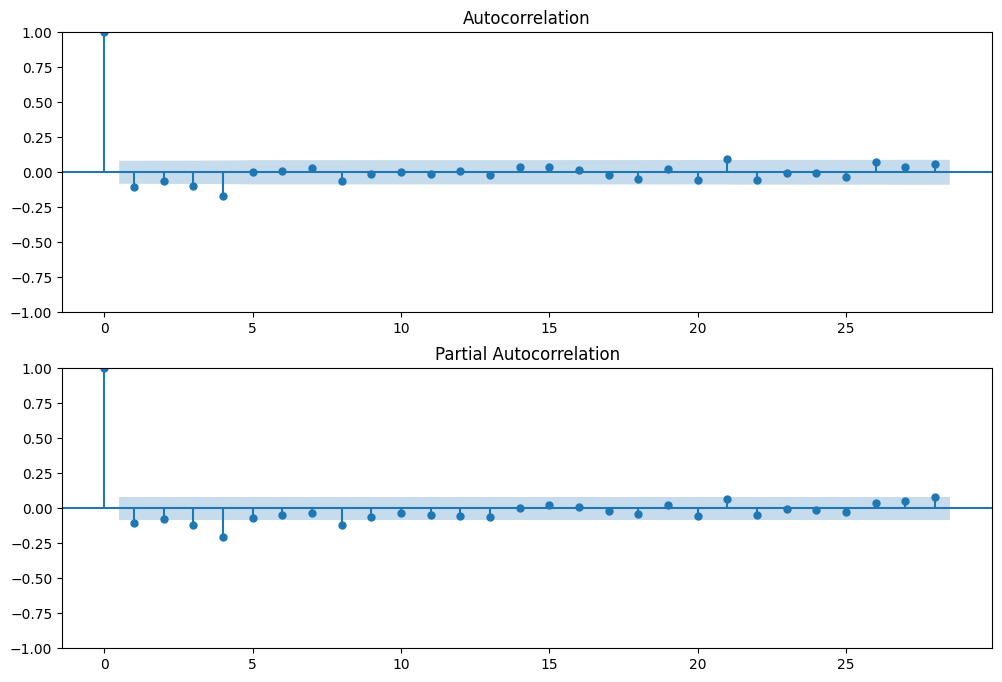

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF of the differenced series
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, ax=axes[0])
plot_pacf(df_diff, ax=axes[1])
plt.show()

In [87]:
# Define the split points
train_end_date = '2025-06-16' # End of training data
test_start_date = '2025-06-24' # Start of testing data

# Split the data
train = df.loc[:train_end_date]
test = df.loc[test_start_date:]

# Display the shapes of the train and test sets
print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)

# Display the start and end dates of the train and test sets
print("Training set date range:", train.index.min(), "to", train.index.max())
print("Testing set date range:", test.index.min(), "to", test.index.max())

Training set shape: (533, 2)
Testing set shape: (30, 2)
Training set date range: 2024-01-01 00:00:00 to 2025-06-16 00:00:00
Testing set date range: 2025-06-24 00:00:00 to 2025-07-23 00:00:00


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


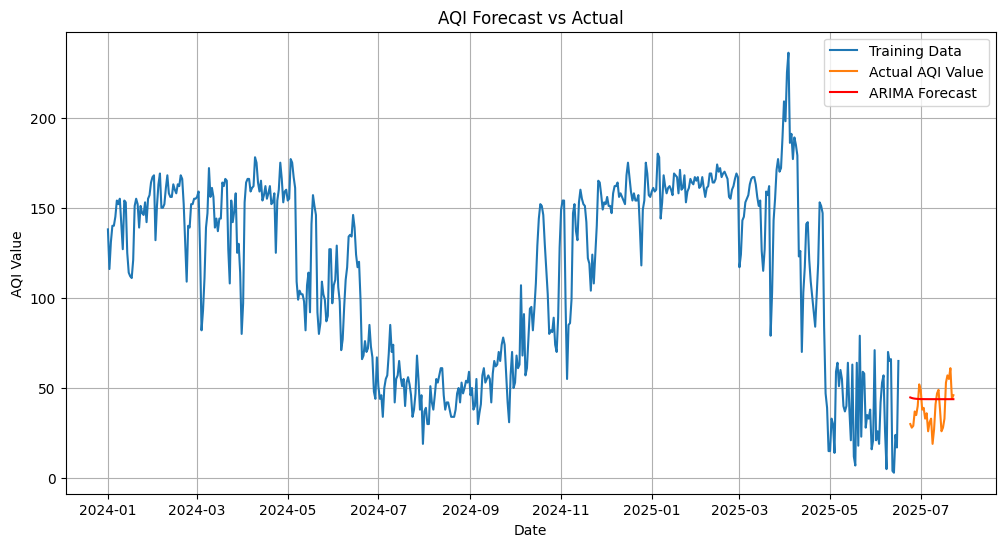

In [138]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model
# Using order (1, 1, 1) based on ACF and PACF plots of the differenced series
model = ARIMA(train['aqi_value'], order=(1, 1, 1))
model_fit = model.fit()



# Forecast the next 30 days
# The start and end points should correspond to the test set index
start_index = test.index.min()
end_index = test.index.max()

forecast = model_fit.predict(start=start_index, end=end_index)


# Visualize actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['aqi_value'], label='Training Data')
plt.plot(test.index, test['aqi_value'], label='Actual AQI Value')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red')
plt.title('AQI Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


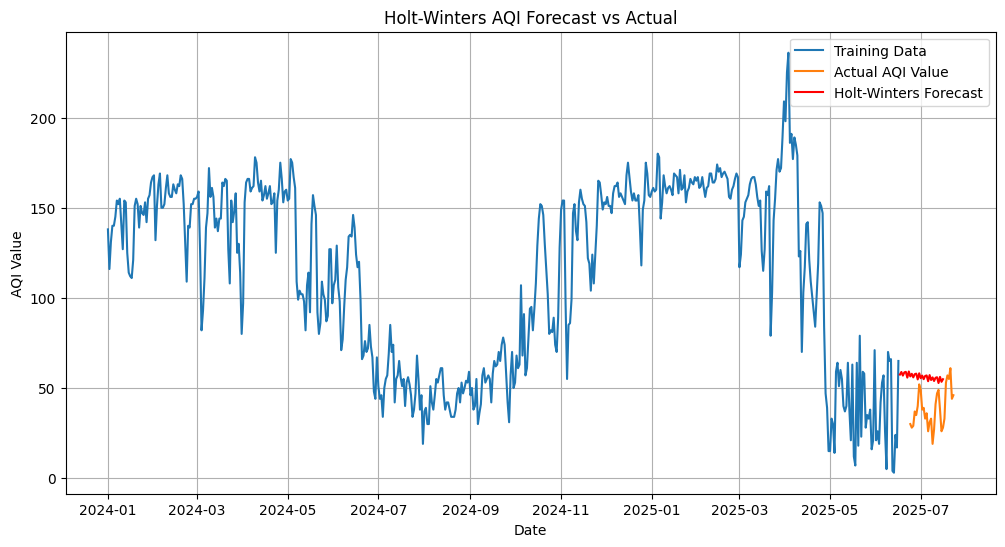

In [113]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit the Holt-Winters model
# Using additive trend and additive seasonality with a period of 7 (weekly)
model_hw = ExponentialSmoothing(train['aqi_value'], trend='add', seasonal='add', seasonal_periods=7)
model_hw_fit = model_hw.fit()

# Forecast the next 30 days
forecast_hw = model_hw_fit.forecast(steps=len(test))



# Visualize actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['aqi_value'], label='Training Data')
plt.plot(test.index, test['aqi_value'], label='Actual AQI Value')
plt.plot(forecast_hw.index, forecast_hw, label='Holt-Winters Forecast', color='red')
plt.title('Holt-Winters AQI Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate ARIMA model
mae_arima = mean_absolute_error(test['aqi_value'], forecast)
rmse_arima = np.sqrt(mean_squared_error(test['aqi_value'], forecast))
# Avoid division by zero in MAPE
mape_arima = np.mean(np.abs((test['aqi_value'] - forecast) / test['aqi_value'])) * 100

print("ARIMA Model Evaluation:")
print(f"  MAE: {mae_arima:.3f}")
print(f"  RMSE: {rmse_arima:.3f}")
# Handle potential inf or NaN in MAPE if test values are zero
if np.isfinite(mape_arima):
    print(f"  MAPE: {mape_arima:.3f}%")
else:
    print("  MAPE: N/A (due to zero actual values)")


# Evaluate Holt-Winters model
mae_hw = mean_absolute_error(test['aqi_value'], forecast_hw)
rmse_hw = np.sqrt(mean_squared_error(test['aqi_value'], forecast_hw))
# Avoid division by zero in MAPE
mape_hw = np.mean(np.abs((test['aqi_value'] - forecast_hw) / test['aqi_value'])) * 100

print("\nHolt-Winters Model Evaluation:")
print(f"  MAE: {mae_hw:.3f}")
print(f"  RMSE: {rmse_hw:.3f}")
# Handle potential inf or NaN in MAPE if test values are zero
if np.isfinite(mape_hw):
    print(f"  MAPE: {mape_hw:.3f}%")
else:
    print("  MAPE: N/A (due to zero actual values)")

ARIMA Model Evaluation:
  MAE: 10.222
  RMSE: 11.744
  MAPE: 31.679%

Holt-Winters Model Evaluation:
  MAE: 18.189
  RMSE: 20.737
  MAPE: 67.533%


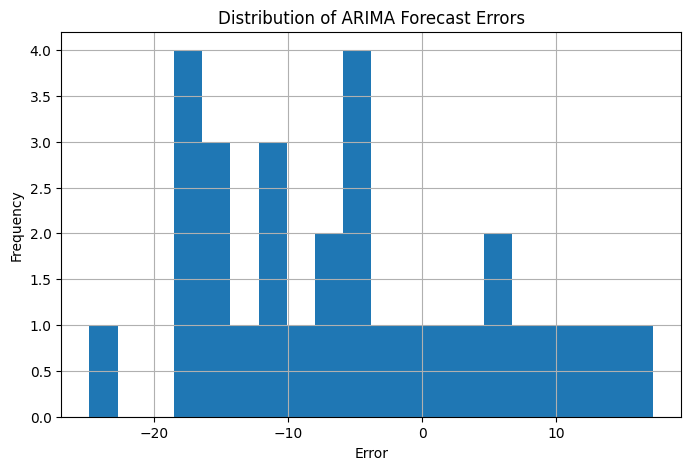

In [92]:
import matplotlib.pyplot as plt

# Calculate errors for ARIMA
errors_arima = test['aqi_value'] - forecast

# Plot histogram of ARIMA errors
plt.figure(figsize=(8, 5))
plt.hist(errors_arima, bins=20)
plt.title('Distribution of ARIMA Forecast Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

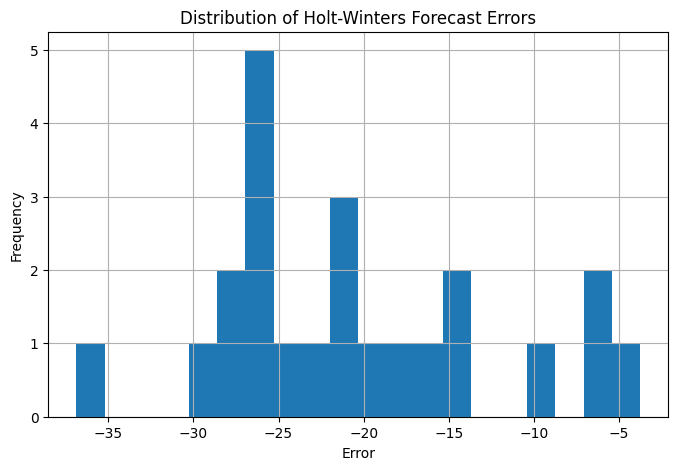

In [93]:
import matplotlib.pyplot as plt

# Calculate errors for Holt-Winters
errors_hw = test['aqi_value'] - forecast_hw

# Plot histogram of Holt-Winters errors
plt.figure(figsize=(8, 5))
plt.hist(errors_hw, bins=20)
plt.title('Distribution of Holt-Winters Forecast Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

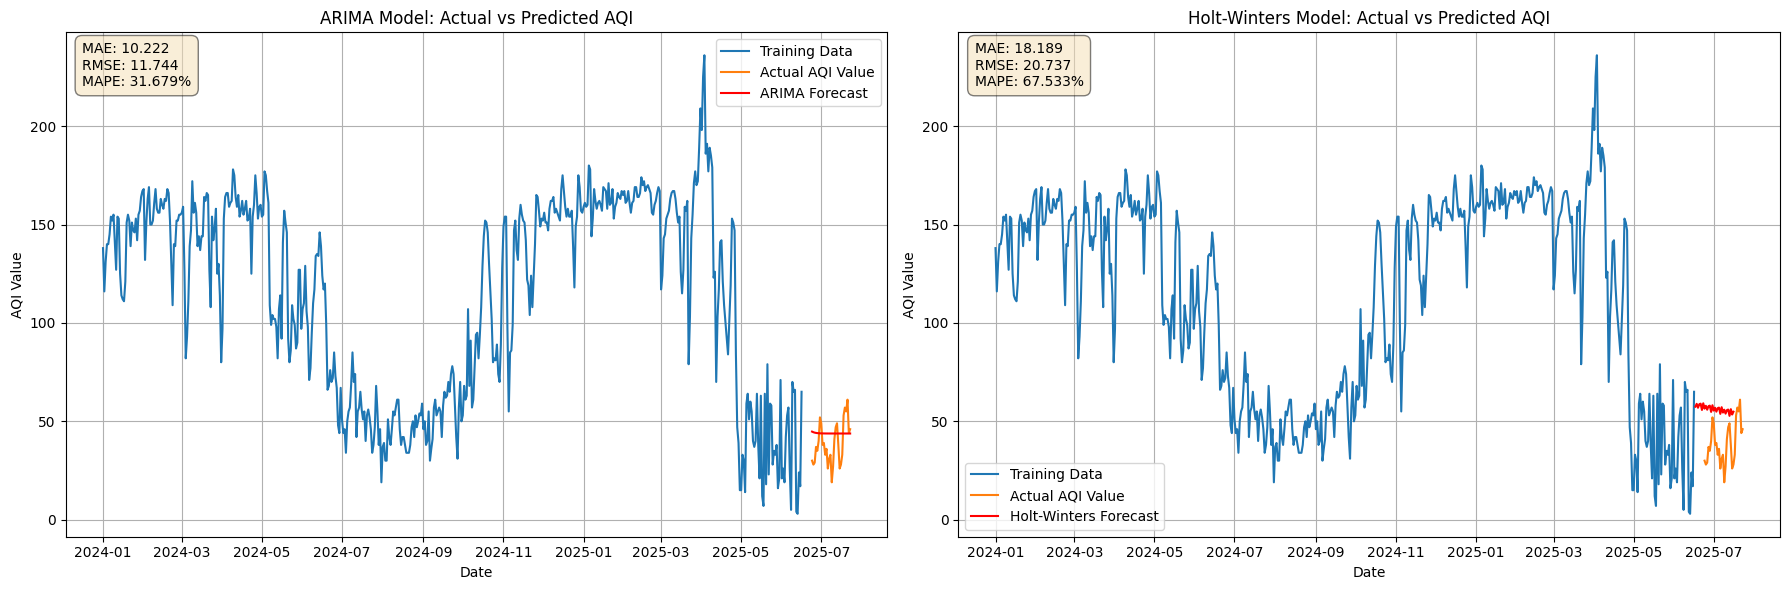

In [111]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side-by-side for Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for ARIMA Actual vs Predicted
axes[0].plot(train.index, train['aqi_value'], label='Training Data')
axes[0].plot(test.index, test['aqi_value'], label='Actual AQI Value')
axes[0].plot(forecast.index, forecast, label='ARIMA Forecast', color='red')
axes[0].set_title('ARIMA Model: Actual vs Predicted AQI')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('AQI Value')
axes[0].legend()
axes[0].grid(True)
# Add accuracy metrics for ARIMA
axes[0].text(0.02, 0.98, f'MAE: {mae_arima:.3f}\nRMSE: {rmse_arima:.3f}\nMAPE: {mape_arima:.3f}%',
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


# Plot for Holt-Winters Actual vs Predicted
axes[1].plot(train.index, train['aqi_value'], label='Training Data')
axes[1].plot(test.index, test['aqi_value'], label='Actual AQI Value')
axes[1].plot(forecast_hw.index, forecast_hw, label='Holt-Winters Forecast', color='red')
axes[1].set_title('Holt-Winters Model: Actual vs Predicted AQI')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('AQI Value')
axes[1].legend()
axes[1].grid(True)
# Add accuracy metrics for Holt-Winters
axes[1].text(0.02, 0.98, f'MAE: {mae_hw:.3f}\nRMSE: {rmse_hw:.3f}\nMAPE: {mape_hw:.3f}%',
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


plt.tight_layout()
plt.show()

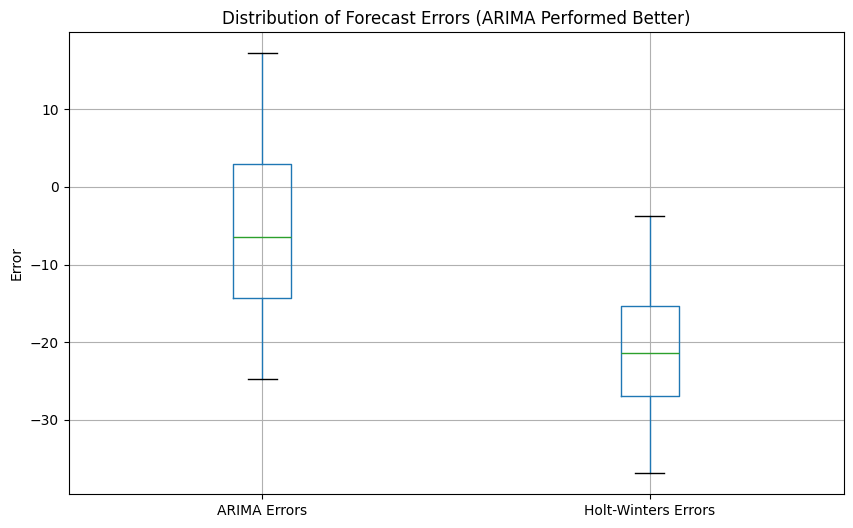

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate errors for both models
errors_arima = test['aqi_value'] - forecast
errors_hw = test['aqi_value'] - forecast_hw

# Create a DataFrame for easier plotting of boxplots side-by-side
error_df = pd.DataFrame({'ARIMA Errors': errors_arima, 'Holt-Winters Errors': errors_hw})

# Plot boxplots of error distributions side-by-side
plt.figure(figsize=(10, 6))
error_df.boxplot()
plt.title('Distribution of Forecast Errors (ARIMA Performed Better)')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [96]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Re-train the ARIMA model on the full dataset
# Using the same order (1, 1, 1)
full_model = ARIMA(df['aqi_value'], order=(1, 1, 1))
full_model_fit = full_model.fit()

# Define the start and end dates for the 7-day forecast
last_date = df.index.max()
forecast_start_date = last_date + pd.DateOffset(days=1)
forecast_end_date = forecast_start_date + pd.DateOffset(days=6) # Forecast for 7 days

# Forecast the next 7 days
forecast_7_days = full_model_fit.predict(start=forecast_start_date, end=forecast_end_date)

# Display the 7-day forecast
print("7-Day AQI Forecast:")
print(forecast_7_days)

7-Day AQI Forecast:
2025-07-24    45.372362
2025-07-25    44.949232
2025-07-26    44.663973
2025-07-27    44.471662
2025-07-28    44.342013
2025-07-29    44.254608
2025-07-30    44.195683
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


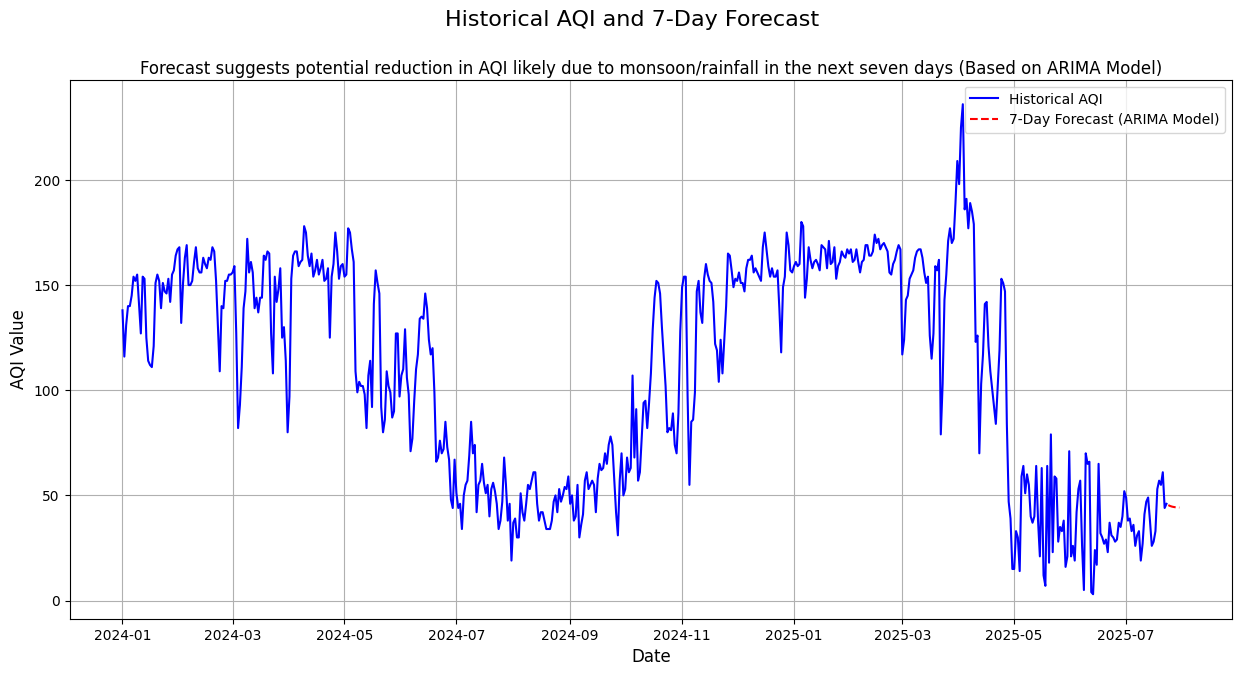

In [141]:
import matplotlib.pyplot as plt

# Plot historical data and the 7-day forecast
plt.figure(figsize=(15, 7))

# Plot historical AQI data
plt.plot(df.index, df['aqi_value'], label='Historical AQI', color='blue')

# Plot the 7-day forecast
plt.plot(forecast_7_days.index, forecast_7_days, label='7-Day Forecast (ARIMA Model)', color='red', linestyle='--')

# Add a professional title and labels
plt.suptitle('Historical AQI and 7-Day Forecast', fontsize=16)
plt.title('Forecast suggests potential reduction in AQI likely due to monsoon/rainfall in the next seven days (Based on ARIMA Model)', fontsize=12, y=0.995) # Update subtitle and position
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend()
plt.grid(True)


plt.show()

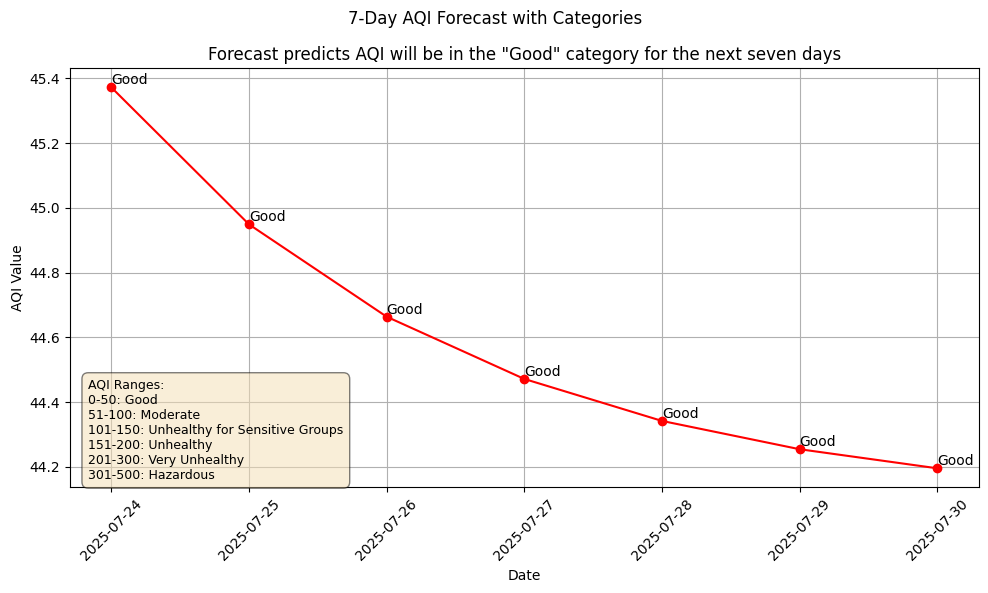

In [155]:
import matplotlib.pyplot as plt

# Plot the 7-day forecast with categories
plt.figure(figsize=(10, 6))
plt.plot(forecast_7_days.index, forecast_7_days, marker='o', linestyle='-', color='red')

# Add text annotations for AQI category
for date, aqi_value, category in zip(forecast_7_days.index, forecast_7_days, forecast_7_days_categories):
    plt.text(date, aqi_value, f'{category}', ha='left', va='bottom')

plt.suptitle('7-Day AQI Forecast with Categories')
plt.title('Forecast predicts AQI will be in the "Good" category for the next seven days', fontsize=12) # Short summary in subtitle

plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.grid(True)
plt.xticks(rotation=45)
# Add text box for AQI ranges
aqi_ranges_text = """AQI Ranges:
0-50: Good
51-100: Moderate
101-150: Unhealthy for Sensitive Groups
151-200: Unhealthy
201-300: Very Unhealthy
301-500: Hazardous"""

plt.text(0.02, 0.02, aqi_ranges_text, transform=plt.gca().transAxes, fontsize=9, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))



plt.tight_layout()
plt.show()

## Project Summary: 7-Day AQI Forecasting (Kathmandu)

This project explored classical time series forecasting methods to predict Air Quality Index (AQI) values for Kathmandu using historical data from January 2024 to July 2025.

**Key Steps and Findings:**

*   **Data Preparation:** The dataset was loaded, cleaned (missing values handled with linear interpolation, duplicates aggregated by daily mean), and prepared for time series analysis.
*   **Exploratory Analysis:** Visualizations revealed seasonality in the AQI data, with lower values typically in the rainy season (June-Sept) and higher values in the dry season (Jan-Mar). Time series decomposition helped visualize these components.
*   **Stationarity:** The initial AQI series was found to be non-stationary using the Augmented Dickey-Fuller test and ACF/PACF plots. First-order differencing was applied to achieve stationarity.
*   **Modeling:** ARIMA and Holt-Winters models were trained and evaluated on a train-test split of the data.
*   **Evaluation:** The ARIMA model (with an order of 1, 1, 1 based on ACF/PACF plots of the differenced series) demonstrated better performance on the test set compared to the Holt-Winters model, based on metrics like MAE, RMSE, and MAPE.
    *   **Best Performing Model:** ARIMA
    *   **Model Evaluation:**
          - MAE: 10.222
          - RMSE: 11.744
          - MAPE: 31.679%
*   **Forecasting:** The final ARIMA model was re-trained on the full dataset to generate a 7-day AQI forecast for the period of July 24, 2025, to July 30, 2025. The predicted AQI values were converted into standard AQI categories.

    *   **AQI Forecast for Next Week:** The forecast predicts that the AQI for the next seven days will be in the **"Good"** category.

This project demonstrates the application of classical time series techniques for air quality forecasting, providing insights that can potentially support public health decisions.